### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File 'RGBNIR_DSM_CHM_VIf_v4.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr"
```
- last commands will install julia libraries, necessary to run the notebook.
- 
- To visualize the results install Jinja2
```bash
conda install jinja2
```

### Running PySR 

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
import skill_metrics as sm
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

### Set up PySR run:


NDVIc scenario

In [5]:
df = pd.read_csv(r"C:\Github\PySR_ATeam_sac\examples\LAI_vineyard_equations\Data\03_df_bands_structure_VI_LAI_transect.csv")
# print(df.head())
cols_to_keep = ["CH", "FC", "BAI", "SR", "c_depth", "VARI", "MRBVI", "GNDVI"]
new_df = df[cols_to_keep].copy()
X = new_df
y = df.LAI
print(X.head())
# X.head()

         CH        FC        BAI        SR   c_depth      VARI     MRBVI  \
0  1.972603  0.439236  17.030671  4.835515  1.429447  0.005512  0.961170   
1  1.946317  0.383681  16.849939  4.422714  1.474576 -0.026121  0.965880   
2  1.988539  0.274306  18.916874  3.957729  1.550626 -0.064176  0.964445   
3  2.024439  0.307292  18.399806  3.838754  1.559624 -0.045575  0.962725   
4  1.946801  0.130208  18.875765  3.665633  1.447568 -0.074738  0.963569   

      GNDVI  
0  0.654350  
1  0.645613  
2  0.633660  
3  0.613741  
4  0.616232  


The default parameters will help speed up code and ensure repeteability of run

In [6]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= "L2DistLoss()",  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [7]:
# Learn equations
model = PySRRegressor(
    niterations=10000000,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=3600*24,  # this line will make the code stop after 2 hours
    binary_operators=["+", "*","-","/"], # these are the default binary operators (use these for basic equations)
    # binary_operators=["+", "*","-","/","nd(x,y) = ((x-y)/(x+y))", "sr(x,y)=x/y"], # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    # unary_operators=["sqrt", "exp", "log", "inv(x)=1/x"], # other basic operators can be added here
    # extra_sympy_mappings={"inv": lambda x: 1 / x,"nd": lambda x, y: ((x- y)/(x+y)),"sr": lambda x, y: x/y}, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)

c:\Users\alvar\anaconda3\envs\pySR\Lib\site-packages\pysr\sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\alvar\anaconda3\envs\pySR\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


,model_selection,'best'
,binary_operators,"['+', '*', ...]"
,unary_operators,None
,expression_spec,None
,niterations,10000000
,populations,31
,population_size,27
,max_evals,None
,maxsize,50
,maxdepth,None
,warmup_maxsize_by,None


In [8]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           2.367226   
	1         0.325454                                      3.435755 / CH   
	2         0.202856                              2.5136766 / (CH - FC)   
	3         0.092105                ((CH - FC) * -2.3525321) + 5.184006   
	4         0.010467       ((FC + 2.2135975) - CH) * (2.3468027 - VARI)   
	5         0.046197  ((CH - (FC / (VARI + 0.60658777))) * -2.199253...   
	6         0.022482  ((2.3489943 - VARI) * ((FC + 2.2349484) - CH))...   
	7   >>>>  0.030835  ((4.026755 / BAI) + (1.429788 - VARI)) * (2.25...   
	8         0.018998  ((-0.0029876938 / FC) + (FC + (2.3755755 - CH)...   
	9         0.020081  (((3.782226 / BAI) + 1.5315768) - VARI) * ((((...   
	10        0.014647  (7.0590186 / BAI) + (((c_depth - 1.8452015) * ...   
	11        0.027311  (((CH + -2.176972) * ((c_depth - 2.090285) * (...   
	12      

We can print the model pareto curve, which will showcase the trend of discovered solutions:

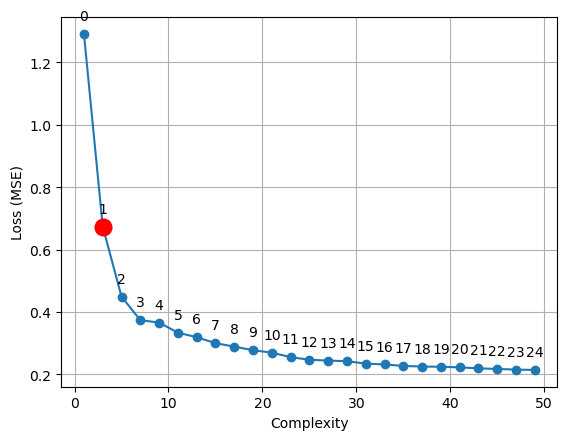

In [16]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
max_index = scores.idxmax(axis=0)
max_index


# Get the index of the equation chosen by model_selection
# selected_index = model.equations_.index[model.equations_["selected"]].tolist()[0]

# print("Selected equation index:", selected_index)

pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [10]:
model.sympy()

(-CH + FC*1.6128174 + 2.2579322)*(-VARI + 1.429788 + 4.026755/BAI)

In [ ]:
model.sympy(9)  # get the 10th equation in sympy format

(-CH + FC*1.6128174 + 2.2579322)*(-VARI + 1.429788 + 4.026755/BAI)

In this run, Eq 1 was the best, so:

In [11]:
model.sympy(17)

CH*(FC - 0.27362937) + (7.819715 - 0.079419754/FC)/(BAI + (c_depth*2.1122751*BAI - SR2)*(BCC + CH*(CH - 2.3565423) + c_depth)) + 2.0454676/CH

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [17]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291319,2.367226
1,0.673516,3.435755 / CH
2,0.448900,2.5136766 / (CH - FC)
3,0.373378,((CH - FC) * -2.3525321) + 5.184006
4,0.365643,((FC + 2.2135975) - CH) * (2.3468027 - VARI)
5,0.333373,((CH - (FC / (VARI + 0.60658777))) * -2.1992533) + 4.5557036
6,0.318715,((2.3489943 - VARI) * ((FC + 2.2349484) - CH)) + (-0.0066803936 / FC)
7,0.299654,((4.026755 / BAI) + (1.429788 - VARI)) * (2.2579322 + ((FC * 1.6128174) - CH))
8,0.288482,((-0.0029876938 / FC) + (FC + (2.3755755 - CH))) * (((3.6552927 / BAI) + 1.6626666) - VARI)
9,0.277126,(((3.782226 / BAI) + 1.5315768) - VARI) * ((((FC * 1.3910253) + 2.3057294) - CH) + (-0.0025362577 / FC))


## Output

Plotting the first solutions

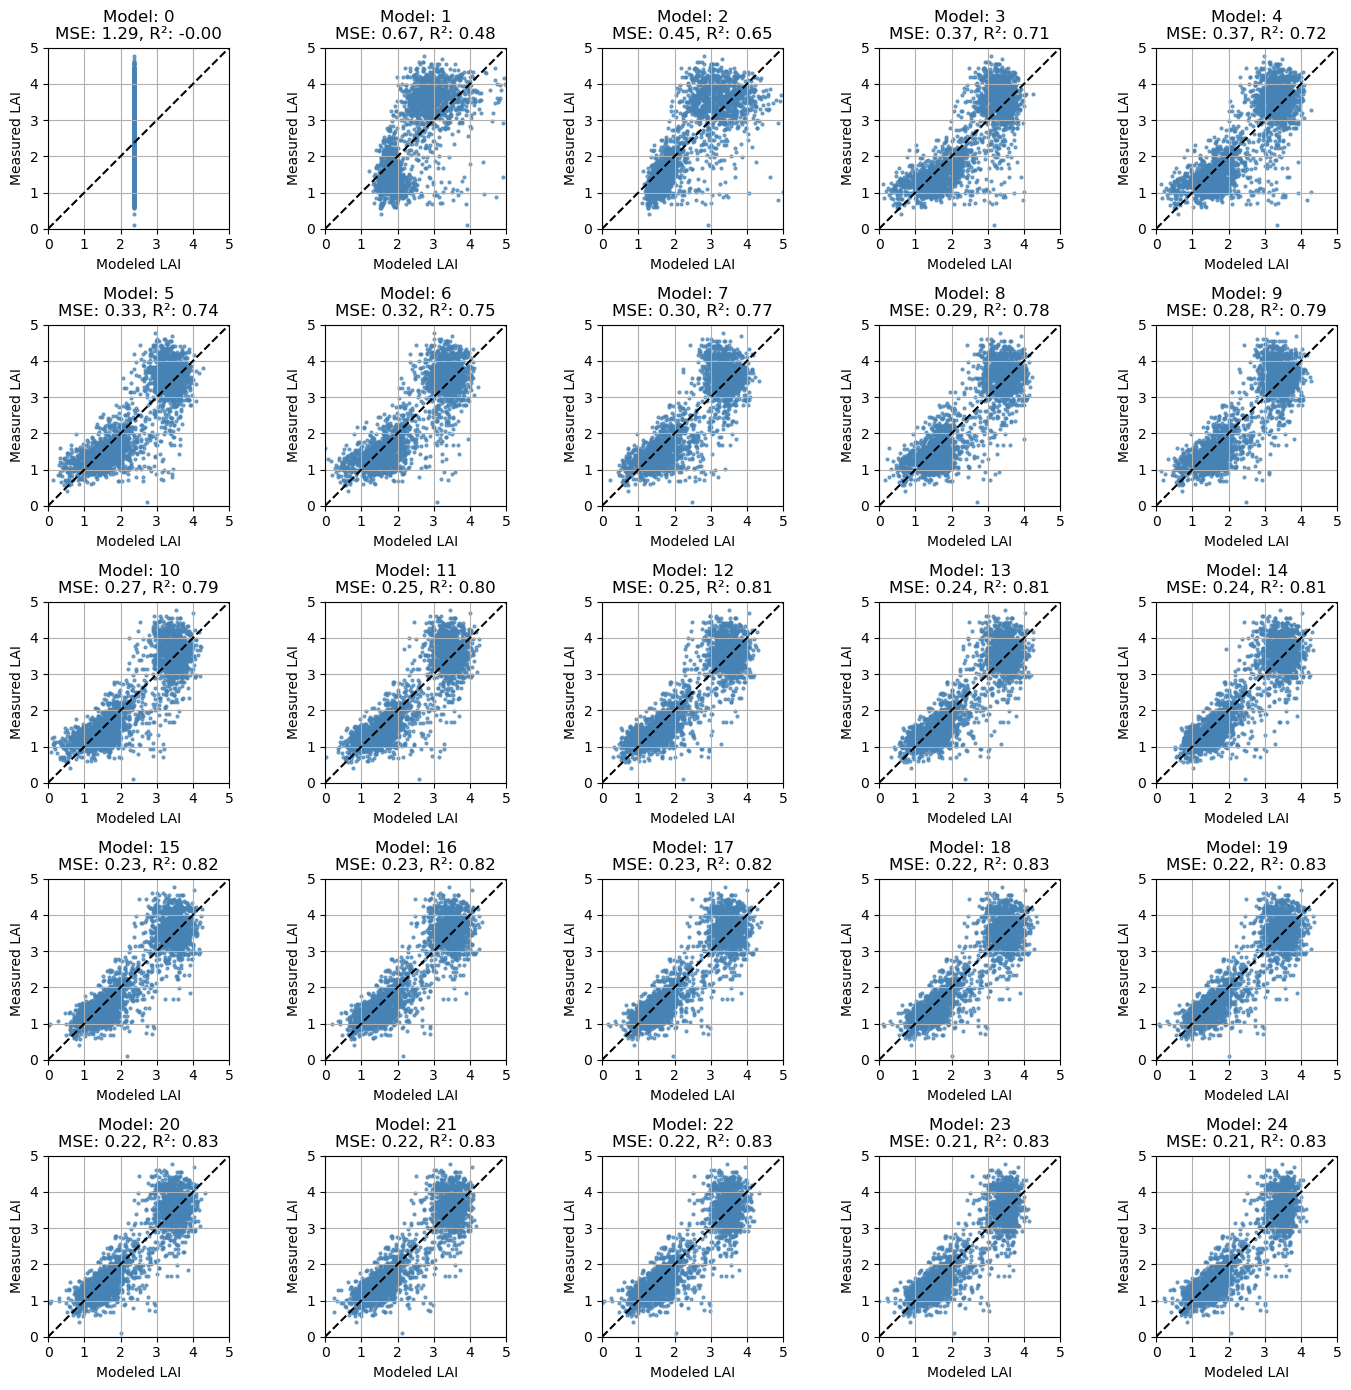

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
# Setting plottin parameters
# Number of plots based on columns in X df
Num_eqs = len(model.equations_)

# # Setting the plot grid (subplot) dimensions
Number_cols = 5
Number_rows = int(np.ceil(Num_eqs / Number_cols))

# Creating a grid of subplots 
fig, axes = plt.subplots(Number_rows, Number_cols, figsize=(14, 14))
# Range of PySR equations for iterations 
equation_indices =range(len(model.equations_))


# Loop through each subplot and each equation index
for ax, column in zip(axes.flatten(), equation_indices): # 

    # -----------------------------
    # 1. Compute predictions
    # -----------------------------
    y_modeled = model.predict(X, index=column)   # Modeled LAI (x-axis)
    y_measured = y                               # Measured LAI (y-axis)

    # -----------------------------
    # 2. Scatter plot
    # -----------------------------
    ax.scatter(
        y_modeled, 
        y_measured, s = 4, alpha = 0.7, c='steelblue',
        label="Data points"
    )

    # 1:1 reference line (perfect agreement)
    ax.plot([0, 5], [0, 5], '--k', label="1:1 line")

    # -----------------------------
    # 3. Axis formatting
    # -----------------------------
    ax.set_xlabel("Modeled LAI")
    ax.set_ylabel("Measured LAI")
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')
    # Set tick locations explicitly
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.grid(True)

    # -----------------------------
    # 4. Compute metrics
    # -----------------------------
    mse = np.mean((y_modeled - y_measured)**2)
    r2 = r2_score(y_measured, y_modeled)

    # -----------------------------
    # 5. Title with equation index + metrics
    # -----------------------------
    ax.set_title(
        f"Model: {column}\n"
        f"MSE: {mse:.2f}, R²: {r2:.2f}"
    )

# Improve spacing between subplots
plt.tight_layout()
plt.show()

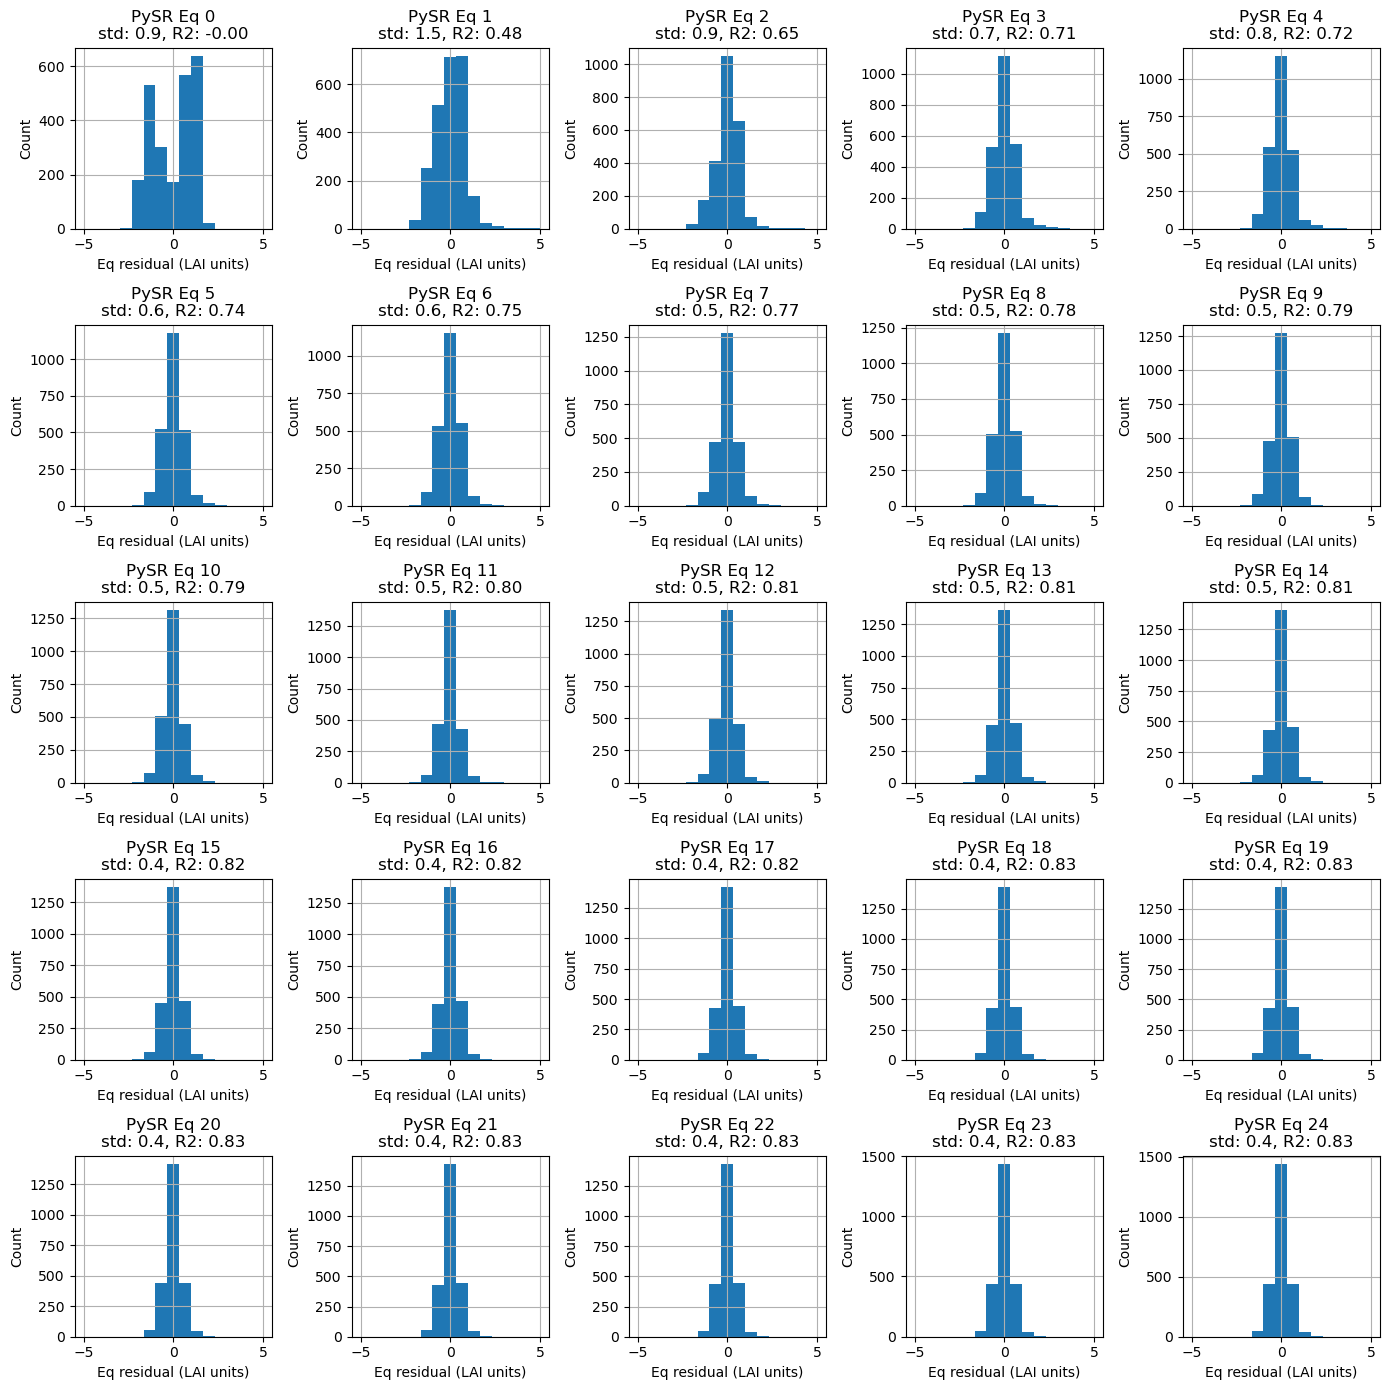

In [25]:

# Creating a grid of subplots 
fig, axes = plt.subplots(Number_rows, Number_cols, figsize=(14, 14))

# Range of PySR equations for iterations 
equation_indices =range(len(model.equations_))

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), equation_indices):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y,range=(-5,5), bins=15)
    ax.grid(True)
    ax.set_xlabel("Eq residual (LAI units)")
    ax.set_ylabel("Count")
    # # Set tick locations explicitly
    # ax.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )

    # ax.set_aspect('equal')
    # ax.set_xlim(0, 70)
    # ax.set_ylim(0, 70)
    std =np.std(np.power(ypredict_simpler - y, 2)).mean()
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Create a Taylor diagram with labeled data points and modified axes

c:\Users\alvar\anaconda3\envs\pySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\alvar\anaconda3\envs\pySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


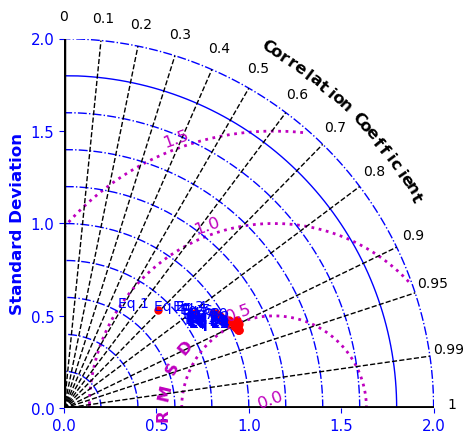

In [26]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api